définition des classes

In [4]:
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class plant:
    objs = []
    
    def __init__(self, ID_nb, species):
        plant.objs.append(self)
        self.ID_nb = ID_nb
        self.species = species
        self.Dm = 0.001 #[g]
        self.Fm = 0 #[g]
    
   
    def dDmdt (self,Dm, t, T, CO2_air, PAR): 
        # #définition des constantes et des paramètres       
        c_alpha = 0.68 #[-]
        c_bheta = 0.8 #[-]
        c_bnd = 0.004 #[-]
        c_car1 = -1.32 * 10**(-5) #[m/s.°C²]
        c_car2 = 5.94*10**(-4)#[m/s.°C]
        c_car3 =-2.64*10**(-3)#[m/s]
        c_eps = 17*10**(-9)#[kg/J]
        c_T = 7.32 * 10**(-5)#[kg/m³]
        c_k = 0.9 #[-]
        c_lar_d = 62.5#[m²/kg]
        c_Q10_T = 2 #[-]
        c_Q10_resp = 2 #[-]
        c_resp_s = 3.47*10**(-7)#[s-1]
        c_resp_r = 1.16*10**(-7)#[s-1]
        c_stm = 0.007 #[m/s]
        c_t = 0.07 #[-]
        
        #calcul de la résistance de la carboxylation [m/s]
        sigma_car = c_car1*T**(2)+c_car2*T+c_car3
        #calcul de la conductance lumineuse de la canopée [m/s]
        sigma_co2 = ((1/c_bnd)+(1/c_stm)+(1/sigma_car))**(-1)      
        #calcul du point de compensation du CO2 [kg/m³]
        Gam = c_T*c_Q10_T**((T-20)/10)       
        #Calcul du light use efficiency de la photosynthèse [kg/J]
        eps = c_eps*((CO2_air-Gam)/(CO2_air+2*Gam))
        #calcul de la photosynthèse maximale [kg/m².s]
        P_max = (eps*PAR*sigma_co2*(CO2_air-Gam))/(eps*PAR+sigma_co2*(CO2_air-Gam))
        #calcul de la respiration [kg/m².s]
        R = (c_resp_s *(1-c_t)+ c_resp_r*c_t)* Dm*c_Q10_resp**(0.1*T - 2.5)
        #calcul du taux d'assimilation photosynthètique [kg/m².s]
        P = P_max *(1-np.exp(-c_k*c_lar_d*(1-c_t)*Dm))
        #calcul de la dérivée temporelle de la masse sèche [kg/s]
        dDmdt = c_bheta *(c_alpha * P - R)/18 # 18 est le nombre de plantes par m²
        return dDmdt
    
    def fresh_matter (self,Dm):
        #calcul de la masse de matière fraiche d'une laitue [kg/m²] en fonction de sa matière sèche    
        c_fw = 22.5#[-]
        c_t = 0.07 #[-]
        Fm = c_fw*Dm*(1-c_t)
        return Fm
    
    
    def dry_matter (self,model, Dm_0, t0, tf, dt, T, CO2_air, PAR):
        t = np.arange (t0, tf, dt)
        Dm = odeint (model, Dm_0, t, args= (T, CO2_air, PAR, ) )
        return Dm, t

test du modèle de plantes

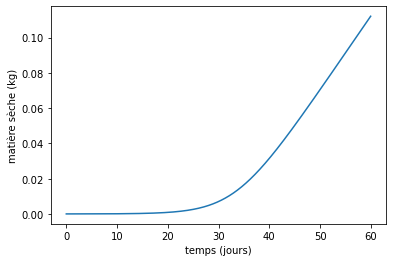

In [7]:
plant1 = plant(1, 'lettuce')

T = 23
CO2_air = 5*10**(-2)
PAR = 100
Dm_0 =0.00001
t0= 0
tf = 24*60*60*60
dt = 3600

# solve ODE
[y,t] = plant1.dry_matter (plant1.dDmdt ,Dm_0, t0, tf, dt, T, CO2_air, PAR)

# plot results
plt.plot(t/(24*60*60),y)
plt.xlabel('temps (jours)')
plt.ylabel('matière sèche (kg)')
plt.show()